In [2]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [5]:
df1 = pd.read_csv("https://raw.githubusercontent.com/nicknochnack/CommentToxicity/main/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")


In [6]:
df1

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [19]:
df1.iloc[278]["comment_text"]

'Hey why you are spreading misconceptions and trying to spread false information to the people.You not even know who won the battle and who lost.you are the cheapest person on the earth.Bloody ignorant fool.Check sources before spreading rumors'

In [20]:
df[df.columns[2:]].iloc[278]

toxic            1
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 278, dtype: int64

In [8]:
from tensorflow.keras.layers import TextVectorization


In [10]:
df = df1.copy()
X = df['comment_text']
y = df[df.columns[2:]].values

In [11]:
MAX_FEATURES = 200000 # number of words in the vocab

In [12]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [27]:
vectorizer("hELLO WORLD")

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([288, 263,   0, ...,   0,   0,   0])>

In [13]:
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [28]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [29]:
dataset.as_numpy_iterator().next()

(array([[     1,    124,      7, ...,      0,      0,      0],
        [  1322,     39,    154, ...,      0,      0,      0],
        [     8,     19, 146948, ...,      0,      0,      0],
        ...,
        [  1955,     13,      2, ...,      0,      0,      0],
        [   316,     52,      3, ...,      0,      0,      0],
        [  1583,    287,     84, ...,      0,      0,      0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [21]:

model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [69]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 770s 109ms/step - loss: 0.0458 - val_loss: 0.0413
Epoch 2/10
6981/6981 [==============================] - 662s 95ms/step - loss: 0.0406 - val_loss: 0.0355
Epoch 3/10
6981/6981 [==============================] - 647s 93ms/step - loss: 0.0361 - val_loss: 0.0318
Epoch 4/10
6981/6981 [==============================] - 646s 93ms/step - loss: 0.0323 - val_loss: 0.0265
Epoch 5/10
6981/6981 [==============================] - 631s 90ms/step - loss: 0.0292 - val_loss: 0.0259
Epoch 6/10
6981/6981 [==============================] - 623s 89ms/step - loss: 0.0263 - val_loss: 0.0235
Epoch 7/10
6981/6981 [==============================] - 626s 90ms/step - loss: 0.0234 - val_loss: 0.0199
Epoch 8/10
6981/6981 [==============================] - 623s 89ms/step - loss: 0.0212 - val_loss: 0.0186
Epoch 9/10
6981/6981 [==============================] - 628s 90ms/step - loss: 0.0191 - val_loss: 0.0163
Epoch 10/10
6981/6981 [==============================]

In [70]:
history.history

{'loss': [0.04584205895662308,
  0.040583472698926926,
  0.03605382516980171,
  0.032346319407224655,
  0.02916550077497959,
  0.026275411248207092,
  0.023440878838300705,
  0.02123448997735977,
  0.019094062969088554,
  0.017441265285015106],
 'val_loss': [0.04134658724069595,
  0.03550311550498009,
  0.03178563341498375,
  0.026450732722878456,
  0.025927916169166565,
  0.023481376469135284,
  0.01991182006895542,
  0.01857663504779339,
  0.016275059431791306,
  0.014228932559490204]}

<Figure size 800x500 with 0 Axes>

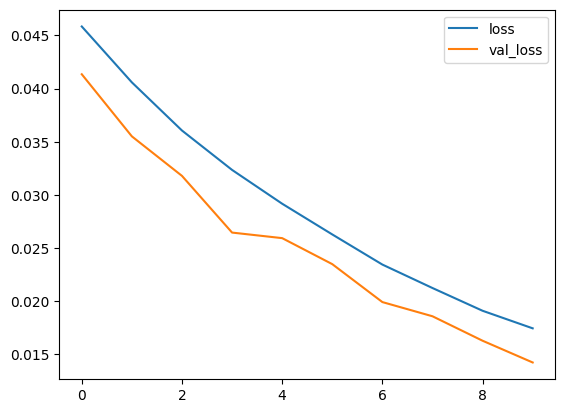

In [71]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [72]:
input_text = vectorizer('You freaking suck! I am going to hit you.')
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0])>

In [73]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [74]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 53ms/step


array([[0.9951054 , 0.42617315, 0.9434058 , 0.09070758, 0.8621814 ,
        0.14496277]], dtype=float32)

In [75]:
batch = test.as_numpy_iterator().next()
batch_x,batch_y =  test.as_numpy_iterator().next()


In [76]:
model.predict(batch_x)

1/1 [==============================] - 0s 60ms/step


array([[3.40469097e-09, 0.00000000e+00, 2.86961888e-13, 3.46821238e-18,
        1.64201411e-12, 7.33734904e-14],
       [4.66896317e-08, 7.12251858e-36, 9.06411265e-11, 2.44534786e-16,
        5.55743021e-11, 7.64000788e-13],
       [3.22880151e-05, 3.43860240e-23, 2.86472158e-07, 8.42337589e-10,
        3.47192753e-07, 3.90602359e-08],
       [3.26169292e-09, 0.00000000e+00, 8.50584739e-13, 4.47070028e-19,
        1.39583635e-12, 3.30934756e-14],
       [8.28370631e-01, 9.98377800e-03, 5.73632956e-01, 1.04268105e-03,
        2.43058100e-01, 4.91839927e-03],
       [1.21964217e-10, 0.00000000e+00, 2.47328369e-14, 7.01075403e-22,
        6.57238868e-15, 8.58433878e-17],
       [6.10933526e-08, 2.57363192e-34, 6.41184605e-10, 1.39968933e-15,
        5.64910375e-11, 8.81398145e-13],
       [2.30314223e-11, 0.00000000e+00, 1.84833283e-16, 3.58025693e-26,
        8.91616315e-16, 3.45720757e-19],
       [4.56250528e-15, 0.00000000e+00, 4.72489960e-20, 2.92162968e-34,
        3.84609420e-21, 

In [77]:
(model.predict(batch_x)>0.5).astype(int)

1/1 [==============================] - 0s 60ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [78]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [79]:

res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 60ms/step


In [80]:
res

array([[0.9951054 , 0.42617315, 0.9434058 , 0.09070758, 0.8621814 ,
        0.14496277]], dtype=float32)

In [81]:
res = model.predict(batch_x)

1/1 [==============================] - 0s 68ms/step


In [82]:
res

array([[3.40469097e-09, 0.00000000e+00, 2.86961888e-13, 3.46821238e-18,
        1.64201411e-12, 7.33734904e-14],
       [4.66896317e-08, 7.12251858e-36, 9.06411265e-11, 2.44534786e-16,
        5.55743021e-11, 7.64000788e-13],
       [3.22880151e-05, 3.43860240e-23, 2.86472158e-07, 8.42337589e-10,
        3.47192753e-07, 3.90602359e-08],
       [3.26169292e-09, 0.00000000e+00, 8.50584739e-13, 4.47070028e-19,
        1.39583635e-12, 3.30934756e-14],
       [8.28370631e-01, 9.98377800e-03, 5.73632956e-01, 1.04268105e-03,
        2.43058100e-01, 4.91839927e-03],
       [1.21964217e-10, 0.00000000e+00, 2.47328369e-14, 7.01075403e-22,
        6.57238868e-15, 8.58433878e-17],
       [6.10933526e-08, 2.57363192e-34, 6.41184605e-10, 1.39968933e-15,
        5.64910375e-11, 8.81398145e-13],
       [2.30314223e-11, 0.00000000e+00, 1.84833283e-16, 3.58025693e-26,
        8.91616315e-16, 3.45720757e-19],
       [4.56250528e-15, 0.00000000e+00, 4.72489960e-20, 2.92162968e-34,
        3.84609420e-21, 

In [83]:
res.flatten().shape

(96,)

In [84]:
res.shape

(16, 6)

In [85]:
(res > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [86]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 55ms/step
Precision: 0.9416884183883667, Recall:0.9151395559310913, Accuracy:0.4603811502456665


In [64]:
!pip install gradio jinja2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9

In [65]:
import tensorflow as tf
import gradio as gr

In [87]:
model.save('toxicity.h5')
model = tf.keras.models.load_model('toxicity.h5')
input_str = vectorizer('hey i freaken hate you!')
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 766ms/step


In [67]:
res

array([[0.8188462 , 0.0153046 , 0.40852448, 0.02318297, 0.39156878,
        0.06788608]], dtype=float32)

In [88]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')
interface.launch(share=True)

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:30: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:30: UserWarning: `numeric` parameter is deprecated, and it has no effect
  super().__init__(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://94d5ffd7ce8c24c314.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
